In [3]:
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.backends import cudnn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm

import cv2
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob


In [4]:
class CustomDNN_MNIST_4Layers(nn.Module):
    def __init__(self, input_size, first_layer, second_layer, third_layer, output_size):
        super(CustomDNN_MNIST_4Layers, self).__init__()
        self.first = nn.Sequential(nn.Linear(input_size, first_layer), nn.BatchNorm1d(first_layer), nn.ReLU(True))
        self.second = nn.Sequential(nn.Linear(first_layer, second_layer), nn.BatchNorm1d(second_layer), nn.ReLU(True))
        self.third = nn.Sequential(nn.Linear(second_layer, third_layer), nn.BatchNorm1d(third_layer), nn.ReLU(True))
        self.fourth = nn.Sequential(nn.Linear(third_layer, output_size))

    def forward(self, x):
        x = self.first(x)
        x = self.second(x)
        x = self.third(x)
        x = self.fourth(x)
        return x

class CustomDNN_MNIST_5Layers(nn.Module):
    def __init__(self):
        super(CustomDNN_MNIST_5Layers, self).__init__()
        self.first = nn.Sequential(nn.Linear(784, 512), nn.BatchNorm1d(512), nn.ReLU(True))
        self.second = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(True))
        self.third = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(True))
        self.fourth = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(True))
        self.fifth = nn.Sequential(nn.Linear(64, 10))

    def forward(self, x):
        x = self.first(x)
        x = self.second(x)
        x = self.third(x)
        x = self.fourth(x)
        x = self.fifth(x)
        return x

def normalize_data(data):
    data = np.array(data)
    data[np.isnan(data)] = 0
    return (data - np.mean(data)) / np.std(data)

def train_model_random_labels(model_class, num_epochs=100, batch_size=2000, num_workers=0, learning_rate=0.01):
    train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

    random.shuffle(train_dataset.train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Dataset Summary: ")
    print(train_dataset.classes)
    print(train_dataset.data.shape)
    print(test_dataset.data.shape)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model_class.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    train_loss_log = []
    test_loss_log = []
    accuracy_log = []
    lr_log = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.view(-1, 784).to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_correct = 0
            total_samples = 0
            for inputs, targets in test_loader:
                inputs, targets = inputs.view(-1, 784).to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                total_test_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                total_correct += (predictions == targets).sum().item()
                total_samples += targets.size(0)

            accuracy = 100.0 * total_correct / total_samples

        lr_scheduler.step()
        lr_log.append(optimizer.state_dict()['param_groups'][0]['lr'])
        train_loss_log.append(total_train_loss)
        test_loss_log.append(total_test_loss)
        accuracy_log.append(accuracy)
        print(f'{epoch+1}/{num_epochs} Test Set: Avg loss: {total_train_loss:.4f}/{total_test_loss:.4f}, Accuracy: {total_correct}/{total_samples} ({accuracy:.2f}%) lr={lr_log[-1]}')

    return [train_loss_log, test_loss_log, accuracy_log, lr_log]



[training_loss, validation_loss, model_accuracy, learning_rates] = train_model_random_labels(CustomDNN_MNIST_5Layers())



100%|████████████████████████████| 9912422/9912422 [00:02<00:00, 3670481.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 17969988.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 3854236.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1245865.46it/s]
/home/mo/anaconda3/envs/spyder-env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset Summary: 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
1/100 Test Set: Avg loss: 70.7330/11.5806, Accuracy: 928/10000 (9.28%) lr=0.01
2/100 Test Set: Avg loss: 68.7263/11.5446, Accuracy: 1238/10000 (12.38%) lr=0.01
3/100 Test Set: Avg loss: 67.9624/11.5394, Accuracy: 1245/10000 (12.45%) lr=0.01
4/100 Test Set: Avg loss: 67.3002/11.6844, Accuracy: 974/10000 (9.74%) lr=0.01
5/100 Test Set: Avg loss: 66.6338/11.5917, Accuracy: 1160/10000 (11.60%) lr=0.008
6/100 Test Set: Avg loss: 65.8305/11.6298, Accuracy: 1222/10000 (12.22%) lr=0.008
7/100 Test Set: Avg loss: 65.0829/11.7261, Accuracy: 1094/10000 (10.94%) lr=0.008
8/100 Test Set: Avg loss: 64.2645/11.8474, Accuracy: 1009/10000 (10.09%) lr=0.008
9/100 Test Set: Avg loss: 63.3124/11.9667, Accuracy: 955/10000 (9.55%) lr=0.008
10

85/100 Test Set: Avg loss: 7.9922/24.0846, Accuracy: 990/10000 (9.90%) lr=0.00022517998136852504
86/100 Test Set: Avg loss: 7.8288/24.0504, Accuracy: 1004/10000 (10.04%) lr=0.00022517998136852504
87/100 Test Set: Avg loss: 7.8070/24.1481, Accuracy: 1002/10000 (10.02%) lr=0.00022517998136852504
88/100 Test Set: Avg loss: 7.7830/24.0892, Accuracy: 1024/10000 (10.24%) lr=0.00022517998136852504
89/100 Test Set: Avg loss: 7.7130/24.1367, Accuracy: 1032/10000 (10.32%) lr=0.00022517998136852504
90/100 Test Set: Avg loss: 7.6878/24.1380, Accuracy: 1012/10000 (10.12%) lr=0.00018014398509482005
91/100 Test Set: Avg loss: 7.6008/24.2561, Accuracy: 994/10000 (9.94%) lr=0.00018014398509482005
92/100 Test Set: Avg loss: 7.5428/24.3403, Accuracy: 986/10000 (9.86%) lr=0.00018014398509482005
93/100 Test Set: Avg loss: 7.5335/24.2266, Accuracy: 1031/10000 (10.31%) lr=0.00018014398509482005
94/100 Test Set: Avg loss: 7.4906/24.4100, Accuracy: 981/10000 (9.81%) lr=0.00018014398509482005
95/100 Test Set: A

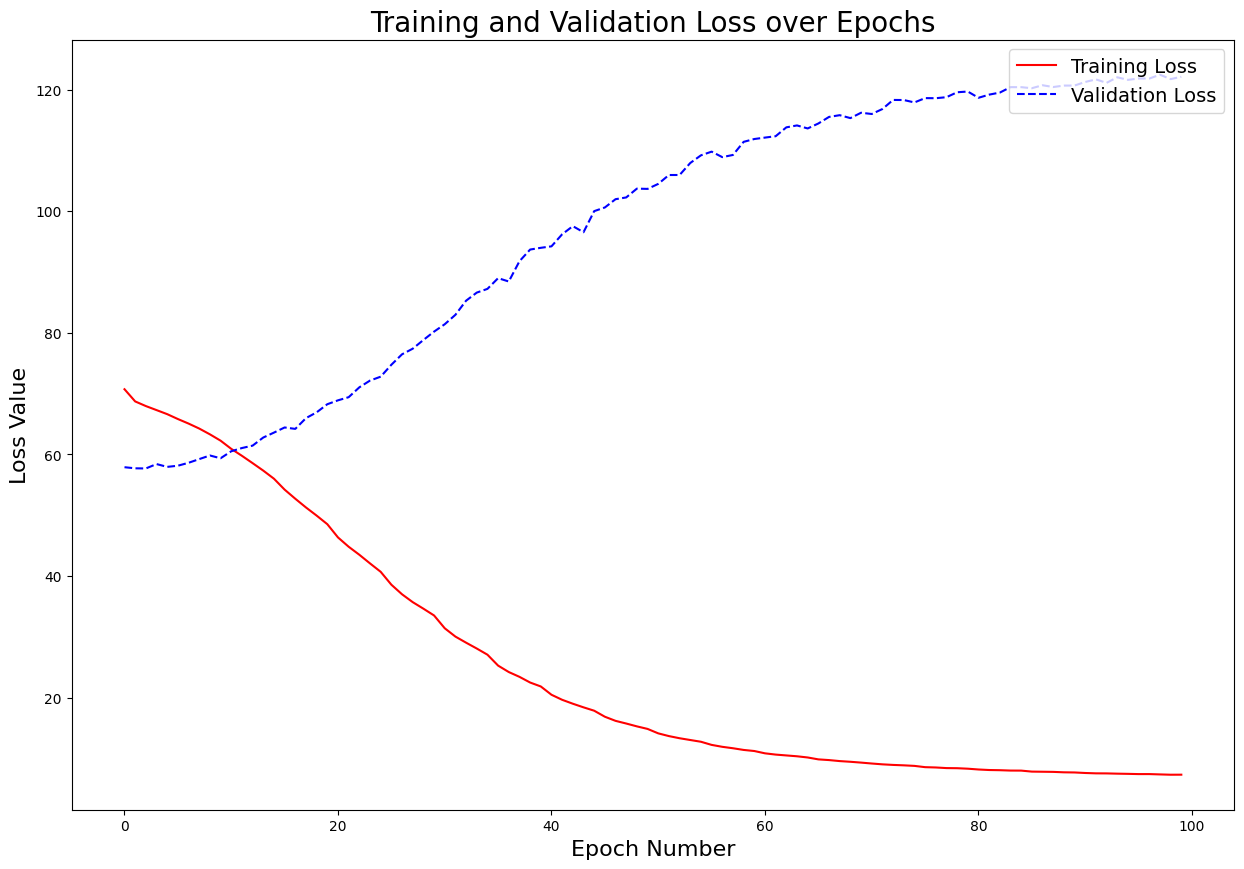

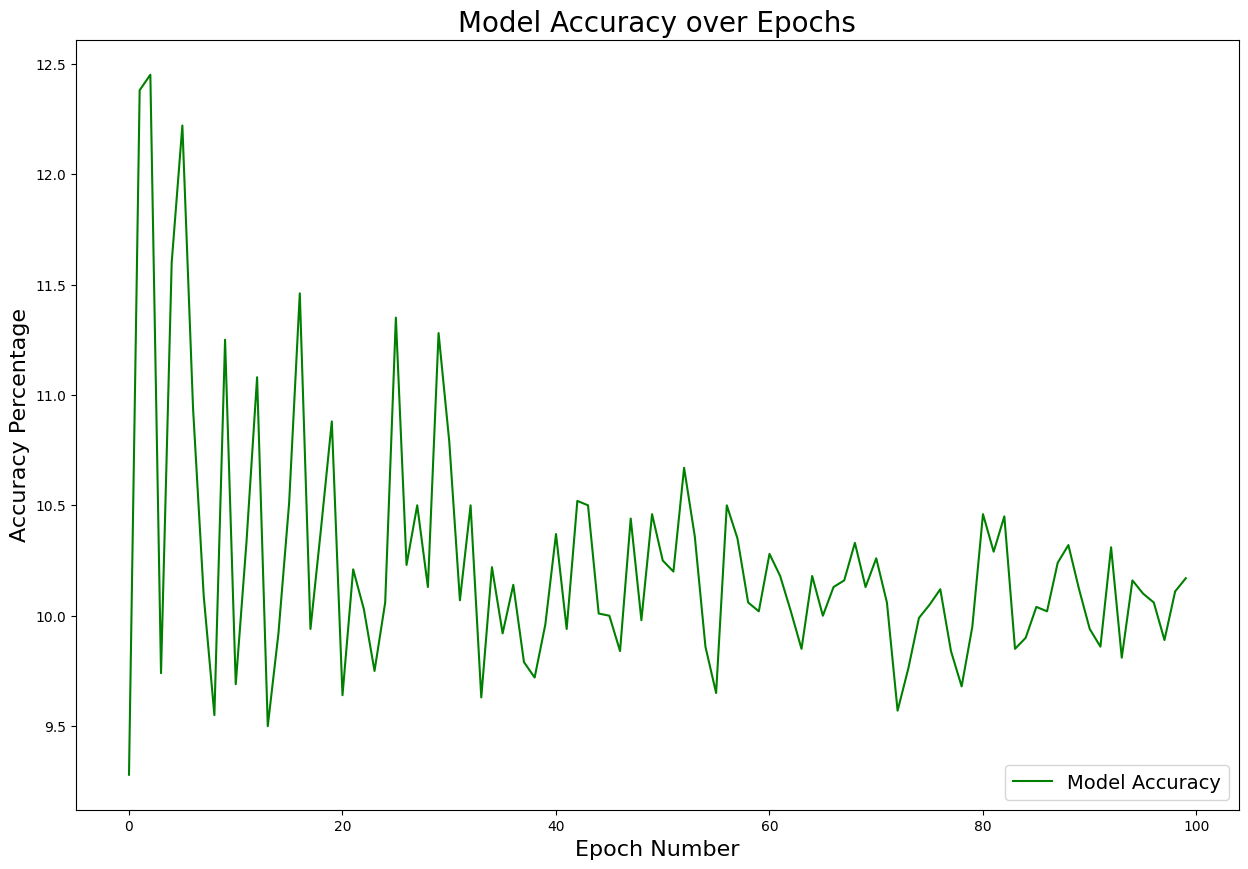

In [5]:
def visualize_results(training_loss, test_loss_log, accuracy_log):
    plt.figure(figsize=(15,10))
    plt.plot(np.array(training_loss), 'r-', label='Training Loss')
    plt.plot(np.array(test_loss_log) * 5, 'b--', label='Validation Loss')
    plt.xlabel('Epoch Number', fontsize=16)
    plt.ylabel('Loss Value', fontsize=16)
    plt.title('Training and Validation Loss over Epochs', fontsize=20)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(accuracy_log, 'g-', label='Model Accuracy')
    plt.xlabel('Epoch Number', fontsize=16)
    plt.ylabel('Accuracy Percentage', fontsize=16)
    plt.title('Model Accuracy over Epochs', fontsize=20)
    plt.legend(loc='lower right', fontsize=14)
    plt.show()

visualize_results(training_loss, validation_loss, model_accuracy)


In [6]:
def train_CIFAR10_custom(model_name, Epochs=25, Batch=1800, Data_workers=2, LR=0.09):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.48, 0.48, 0.48), (0.52, 0.52, 0.52))  # Slightly adjusted color normalization
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader = DataLoader(testset, batch_size=Batch, shuffle=False, num_workers=Data_workers)
    
    print("Dataset Information : ")
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    Model = model_name.to(device)

    number_of_param = sum(param.numel() for param in Model.parameters())
    
    print(model_name)
    print('Number of total parameters: ', number_of_param)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.88)  # Slightly adjusted momentum
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.85)  # Adjusted step size and gamma

    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    learning_rate_list = []
    
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        correct_preds = 0
        total_samples = 0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = images.view(-1, 3*32*32).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = Model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == labels).sum().item()
        total_samples = len(trainloader.dataset)
        train_accuracy = 100 * correct_preds / total_samples

        Model.eval()
        test_loss = 0.0
        correct_preds_test = 0
        total_samples_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.view(-1, 3*32*32).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_preds_test += (predicted == labels).sum().item()
            total_samples_test = len(testloader.dataset)
            test_accuracy = 100 * correct_preds_test / total_samples_test

        learning_rate_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        print(f'{epoch+1}/{Epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    return [train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, learning_rate_list, number_of_param]

[train_loss_1,test_loss_1,train_acc_1,test_acc_1,_,num_param_1] = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32, 1, 2, 1, 10), Epochs=25)

[train_loss_2,test_loss_2,train_acc_2,test_acc_2,_,num_param_2] = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,2,4,2,10),Epochs=100)

[train_loss_3,test_loss_3,train_acc_3,test_acc_3,_,num_param_3]      = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,3,6,3,10),Epochs=100)
[train_loss_4,test_loss_4,train_acc_4,test_acc_4,_,num_param_4]      = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,5,10,5,10),Epochs=100)
[train_loss_5,test_loss_5,train_acc_5,test_acc_5,_,num_param_5]       = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,10,20,10,10),Epochs=100)
[train_loss_6,test_loss_6,train_acc_6,test_acc_6,_,num_param_6]     = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,20,40,20,10),Epochs=100)
[train_loss_7,test_loss_7,train_acc_7,test_acc_7,_,num_param_7]       = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,50,100,50,10),Epochs=100)

[train_loss_8,test_loss_8,train_acc_8,test_acc_8,_,num_param_8]     = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,100,200,100,10),Epochs=100)
[train_loss_9,test_loss_9,train_acc_9,test_acc_9,_,num_param_9]     = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,200,400,200,10),Epochs=100)
[train_loss_10,test_loss_10,train_acc_10,test_acc_10,_,num_param_10]  = train_CIFAR10_custom(model_name=CustomDNN_MNIST_4Layers(3*32*32,500,1000,500,10),Epochs=100)


100%|████████████████████████| 170498071/170498071 [00:31<00:00, 5334481.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
Dataset Information : 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
(10000, 32, 32, 3)
CustomDNN_MNIST_4Layers(
  (first): Sequential(
    (0): Linear(in_features=3072, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (second): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (third): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fourth): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
  )
)
Number of total parameters:  3108
1/2

49/100 - Train Loss: 52.5552, Test Loss: 11.4048, Train Acc: 27.38%, Test Acc: 27.18%
50/100 - Train Loss: 52.5583, Test Loss: 11.4164, Train Acc: 27.46%, Test Acc: 25.70%
51/100 - Train Loss: 52.5271, Test Loss: 11.4046, Train Acc: 27.43%, Test Acc: 26.87%
52/100 - Train Loss: 52.5091, Test Loss: 11.4179, Train Acc: 27.76%, Test Acc: 26.55%
53/100 - Train Loss: 52.5274, Test Loss: 11.4080, Train Acc: 27.66%, Test Acc: 26.91%
54/100 - Train Loss: 52.5172, Test Loss: 11.4308, Train Acc: 27.44%, Test Acc: 26.74%
55/100 - Train Loss: 52.4749, Test Loss: 11.4152, Train Acc: 27.65%, Test Acc: 26.15%
56/100 - Train Loss: 52.4730, Test Loss: 11.4160, Train Acc: 27.73%, Test Acc: 26.66%
57/100 - Train Loss: 52.4469, Test Loss: 11.4202, Train Acc: 27.62%, Test Acc: 26.58%
58/100 - Train Loss: 52.5075, Test Loss: 11.4034, Train Acc: 27.94%, Test Acc: 27.03%
59/100 - Train Loss: 52.4982, Test Loss: 11.4449, Train Acc: 27.60%, Test Acc: 26.16%
60/100 - Train Loss: 52.4565, Test Loss: 11.4389, Trai

33/100 - Train Loss: 51.7110, Test Loss: 11.2147, Train Acc: 30.79%, Test Acc: 30.18%
34/100 - Train Loss: 51.6262, Test Loss: 11.2035, Train Acc: 31.16%, Test Acc: 29.64%
35/100 - Train Loss: 51.4715, Test Loss: 11.1948, Train Acc: 31.45%, Test Acc: 30.52%
36/100 - Train Loss: 51.3547, Test Loss: 11.1343, Train Acc: 31.76%, Test Acc: 30.49%
37/100 - Train Loss: 51.1773, Test Loss: 11.1248, Train Acc: 32.20%, Test Acc: 30.77%
38/100 - Train Loss: 51.1601, Test Loss: 11.0856, Train Acc: 32.03%, Test Acc: 31.09%
39/100 - Train Loss: 50.9666, Test Loss: 11.1004, Train Acc: 32.32%, Test Acc: 30.86%
40/100 - Train Loss: 50.8886, Test Loss: 11.1246, Train Acc: 32.52%, Test Acc: 30.77%
41/100 - Train Loss: 50.7773, Test Loss: 11.0423, Train Acc: 32.39%, Test Acc: 31.26%
42/100 - Train Loss: 50.6515, Test Loss: 11.0593, Train Acc: 32.70%, Test Acc: 31.17%
43/100 - Train Loss: 50.5977, Test Loss: 11.0797, Train Acc: 32.81%, Test Acc: 31.09%
44/100 - Train Loss: 50.6144, Test Loss: 11.0707, Trai

17/100 - Train Loss: 46.9303, Test Loss: 10.3419, Train Acc: 38.06%, Test Acc: 36.08%
18/100 - Train Loss: 46.9327, Test Loss: 10.2505, Train Acc: 37.92%, Test Acc: 37.03%
19/100 - Train Loss: 46.7497, Test Loss: 10.2415, Train Acc: 38.21%, Test Acc: 37.29%
20/100 - Train Loss: 46.5901, Test Loss: 10.2697, Train Acc: 38.44%, Test Acc: 36.84%
21/100 - Train Loss: 46.5998, Test Loss: 10.2273, Train Acc: 38.33%, Test Acc: 37.42%
22/100 - Train Loss: 46.5789, Test Loss: 10.2607, Train Acc: 38.21%, Test Acc: 36.99%
23/100 - Train Loss: 46.4956, Test Loss: 10.2521, Train Acc: 38.75%, Test Acc: 37.18%
24/100 - Train Loss: 46.4036, Test Loss: 10.2642, Train Acc: 38.88%, Test Acc: 37.28%
25/100 - Train Loss: 46.5737, Test Loss: 10.2699, Train Acc: 38.65%, Test Acc: 37.08%
26/100 - Train Loss: 46.3348, Test Loss: 10.2888, Train Acc: 38.88%, Test Acc: 37.06%
27/100 - Train Loss: 46.2367, Test Loss: 10.3497, Train Acc: 38.93%, Test Acc: 36.78%
28/100 - Train Loss: 46.3045, Test Loss: 10.2721, Trai

1/100 - Train Loss: 59.8020, Test Loss: 11.9430, Train Acc: 21.72%, Test Acc: 27.75%
2/100 - Train Loss: 52.6383, Test Loss: 10.8032, Train Acc: 31.46%, Test Acc: 34.76%
3/100 - Train Loss: 49.0433, Test Loss: 10.3158, Train Acc: 36.64%, Test Acc: 37.33%
4/100 - Train Loss: 47.1398, Test Loss: 10.0285, Train Acc: 39.34%, Test Acc: 39.77%
5/100 - Train Loss: 46.0820, Test Loss: 9.9108, Train Acc: 40.71%, Test Acc: 40.30%
6/100 - Train Loss: 45.3386, Test Loss: 9.8160, Train Acc: 41.82%, Test Acc: 41.57%
7/100 - Train Loss: 44.6231, Test Loss: 9.7221, Train Acc: 42.84%, Test Acc: 41.88%
8/100 - Train Loss: 44.1211, Test Loss: 9.6391, Train Acc: 43.67%, Test Acc: 42.40%
9/100 - Train Loss: 43.6943, Test Loss: 9.6763, Train Acc: 44.26%, Test Acc: 42.53%
10/100 - Train Loss: 43.3203, Test Loss: 9.5528, Train Acc: 44.83%, Test Acc: 43.10%
11/100 - Train Loss: 43.0538, Test Loss: 9.5583, Train Acc: 45.24%, Test Acc: 43.24%
12/100 - Train Loss: 42.8140, Test Loss: 9.5918, Train Acc: 45.39%, Te

98/100 - Train Loss: 37.6460, Test Loss: 9.6442, Train Acc: 52.27%, Test Acc: 44.46%
99/100 - Train Loss: 37.5971, Test Loss: 9.7151, Train Acc: 52.17%, Test Acc: 43.94%
100/100 - Train Loss: 37.7062, Test Loss: 9.5977, Train Acc: 52.03%, Test Acc: 44.65%
Files already downloaded and verified
Files already downloaded and verified
Dataset Information : 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
(10000, 32, 32, 3)
CustomDNN_MNIST_4Layers(
  (first): Sequential(
    (0): Linear(in_features=3072, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (second): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (third): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=Tru

83/100 - Train Loss: 30.3533, Test Loss: 9.5085, Train Acc: 61.13%, Test Acc: 47.60%
84/100 - Train Loss: 30.3889, Test Loss: 9.6028, Train Acc: 61.22%, Test Acc: 47.10%
85/100 - Train Loss: 30.3756, Test Loss: 9.5499, Train Acc: 61.20%, Test Acc: 46.91%
86/100 - Train Loss: 30.4290, Test Loss: 9.5000, Train Acc: 61.20%, Test Acc: 46.99%
87/100 - Train Loss: 30.1433, Test Loss: 9.7466, Train Acc: 61.43%, Test Acc: 45.72%
88/100 - Train Loss: 30.3337, Test Loss: 9.4700, Train Acc: 61.36%, Test Acc: 47.24%
89/100 - Train Loss: 30.2248, Test Loss: 9.6154, Train Acc: 61.25%, Test Acc: 47.03%
90/100 - Train Loss: 30.1343, Test Loss: 9.5506, Train Acc: 61.62%, Test Acc: 47.21%
91/100 - Train Loss: 29.9136, Test Loss: 9.5229, Train Acc: 61.80%, Test Acc: 47.56%
92/100 - Train Loss: 30.0208, Test Loss: 9.5998, Train Acc: 61.65%, Test Acc: 47.70%
93/100 - Train Loss: 29.8946, Test Loss: 9.5062, Train Acc: 61.79%, Test Acc: 47.08%
94/100 - Train Loss: 29.9969, Test Loss: 9.6358, Train Acc: 61.83

68/100 - Train Loss: 16.8645, Test Loss: 12.6920, Train Acc: 78.34%, Test Acc: 47.25%
69/100 - Train Loss: 16.9058, Test Loss: 12.5790, Train Acc: 78.39%, Test Acc: 47.14%
70/100 - Train Loss: 16.5739, Test Loss: 12.9387, Train Acc: 78.82%, Test Acc: 47.62%
71/100 - Train Loss: 16.4633, Test Loss: 12.9944, Train Acc: 78.94%, Test Acc: 47.09%
72/100 - Train Loss: 16.2699, Test Loss: 13.0675, Train Acc: 79.34%, Test Acc: 47.02%
73/100 - Train Loss: 16.1595, Test Loss: 13.0440, Train Acc: 79.47%, Test Acc: 46.65%
74/100 - Train Loss: 16.0942, Test Loss: 13.2487, Train Acc: 79.33%, Test Acc: 47.47%
75/100 - Train Loss: 16.1472, Test Loss: 13.1027, Train Acc: 79.32%, Test Acc: 46.95%
76/100 - Train Loss: 15.8232, Test Loss: 13.2027, Train Acc: 79.70%, Test Acc: 47.62%
77/100 - Train Loss: 15.7805, Test Loss: 13.3766, Train Acc: 79.78%, Test Acc: 46.85%
78/100 - Train Loss: 15.4150, Test Loss: 13.3672, Train Acc: 80.37%, Test Acc: 46.74%
79/100 - Train Loss: 15.6029, Test Loss: 13.5473, Trai

53/100 - Train Loss: 5.4724, Test Loss: 17.1304, Train Acc: 93.40%, Test Acc: 49.14%
54/100 - Train Loss: 5.3514, Test Loss: 17.2047, Train Acc: 93.68%, Test Acc: 49.41%
55/100 - Train Loss: 4.6768, Test Loss: 17.5657, Train Acc: 94.56%, Test Acc: 48.69%
56/100 - Train Loss: 4.6775, Test Loss: 17.7722, Train Acc: 94.43%, Test Acc: 49.11%
57/100 - Train Loss: 4.3107, Test Loss: 17.6834, Train Acc: 94.96%, Test Acc: 49.72%
58/100 - Train Loss: 3.9035, Test Loss: 18.2604, Train Acc: 95.60%, Test Acc: 49.30%
59/100 - Train Loss: 3.9148, Test Loss: 18.3794, Train Acc: 95.55%, Test Acc: 49.16%
60/100 - Train Loss: 3.9651, Test Loss: 18.7286, Train Acc: 95.31%, Test Acc: 49.22%
61/100 - Train Loss: 3.9544, Test Loss: 18.8205, Train Acc: 95.43%, Test Acc: 48.57%
62/100 - Train Loss: 3.5032, Test Loss: 18.8579, Train Acc: 96.05%, Test Acc: 50.08%
63/100 - Train Loss: 3.1909, Test Loss: 19.1838, Train Acc: 96.53%, Test Acc: 49.97%
64/100 - Train Loss: 3.0660, Test Loss: 19.5369, Train Acc: 96.60

38/100 - Train Loss: 0.9393, Test Loss: 16.7780, Train Acc: 99.40%, Test Acc: 53.58%
39/100 - Train Loss: 0.7656, Test Loss: 16.9839, Train Acc: 99.51%, Test Acc: 53.61%
40/100 - Train Loss: 0.5884, Test Loss: 17.2941, Train Acc: 99.69%, Test Acc: 53.62%
41/100 - Train Loss: 0.3540, Test Loss: 17.4072, Train Acc: 99.90%, Test Acc: 54.17%
42/100 - Train Loss: 0.2070, Test Loss: 17.5507, Train Acc: 99.97%, Test Acc: 54.04%
43/100 - Train Loss: 0.1257, Test Loss: 17.7566, Train Acc: 99.99%, Test Acc: 54.30%
44/100 - Train Loss: 0.0944, Test Loss: 17.9634, Train Acc: 100.00%, Test Acc: 53.90%
45/100 - Train Loss: 0.0789, Test Loss: 18.0866, Train Acc: 100.00%, Test Acc: 54.12%
46/100 - Train Loss: 0.0704, Test Loss: 18.2575, Train Acc: 100.00%, Test Acc: 54.12%
47/100 - Train Loss: 0.0658, Test Loss: 18.4144, Train Acc: 100.00%, Test Acc: 54.15%
48/100 - Train Loss: 0.0601, Test Loss: 18.5084, Train Acc: 100.00%, Test Acc: 54.32%
49/100 - Train Loss: 0.0562, Test Loss: 18.6588, Train Acc: 

22/100 - Train Loss: 1.5172, Test Loss: 13.4164, Train Acc: 98.71%, Test Acc: 55.45%
23/100 - Train Loss: 0.9844, Test Loss: 13.8246, Train Acc: 99.31%, Test Acc: 55.76%
24/100 - Train Loss: 0.6848, Test Loss: 14.0585, Train Acc: 99.54%, Test Acc: 56.39%
25/100 - Train Loss: 0.4478, Test Loss: 13.9044, Train Acc: 99.77%, Test Acc: 56.17%
26/100 - Train Loss: 0.2712, Test Loss: 14.1187, Train Acc: 99.89%, Test Acc: 56.61%
27/100 - Train Loss: 0.1405, Test Loss: 14.2294, Train Acc: 99.97%, Test Acc: 57.12%
28/100 - Train Loss: 0.0909, Test Loss: 14.3463, Train Acc: 99.99%, Test Acc: 56.85%
29/100 - Train Loss: 0.0647, Test Loss: 14.5127, Train Acc: 100.00%, Test Acc: 57.18%
30/100 - Train Loss: 0.0485, Test Loss: 14.6206, Train Acc: 100.00%, Test Acc: 57.06%
31/100 - Train Loss: 0.0437, Test Loss: 14.7657, Train Acc: 100.00%, Test Acc: 57.24%
32/100 - Train Loss: 0.0410, Test Loss: 14.8918, Train Acc: 100.00%, Test Acc: 57.16%
33/100 - Train Loss: 0.0367, Test Loss: 14.9520, Train Acc: 1

In [8]:

num_param_list = [num_param_1, num_param_2, num_param_3, num_param_4, num_param_5, num_param_6, num_param_7, num_param_8, num_param_9, num_param_10]

train_loss_list = [train_loss_1, train_loss_2, train_loss_3, train_loss_4, train_loss_5, train_loss_6, train_loss_7, train_loss_8, train_loss_9, train_loss_10]

train_loss = [lst[-1] for lst in train_loss_list]
test_loss_list = [test_loss_1, test_loss_2, test_loss_3, test_loss_4, test_loss_5, test_loss_6, test_loss_7, test_loss_8, test_loss_9, test_loss_10]  
test_loss = [lst[-1] for lst in test_loss_list]
train_acc_list = [train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5, train_acc_6, train_acc_7, train_acc_8, train_acc_9, train_acc_10]
train_acc = [lst[-1] for lst in train_acc_list]
test_acc_list = [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5, test_acc_6, test_acc_7, test_acc_8, test_acc_9, test_acc_10]
test_acc = [lst[-1] for lst in test_acc_list]

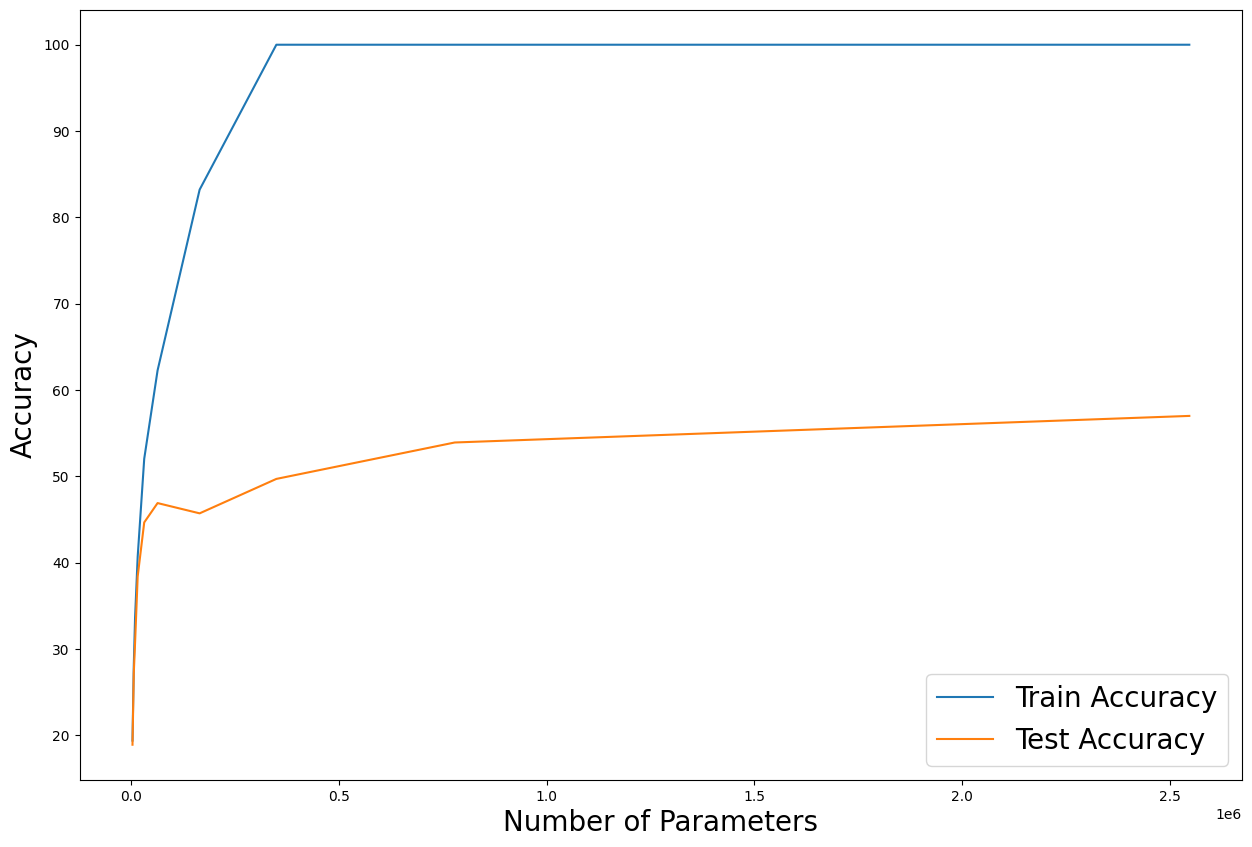

In [31]:

plt.figure(figsize=(15, 10))
plt.plot(num_param_list, train_acc, label='Train Accuracy')  
plt.plot(num_param_list, test_acc, label='Test Accuracy')  
plt.xlabel('Number of Parameters', fontsize=20)  
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=20)
plt.show()

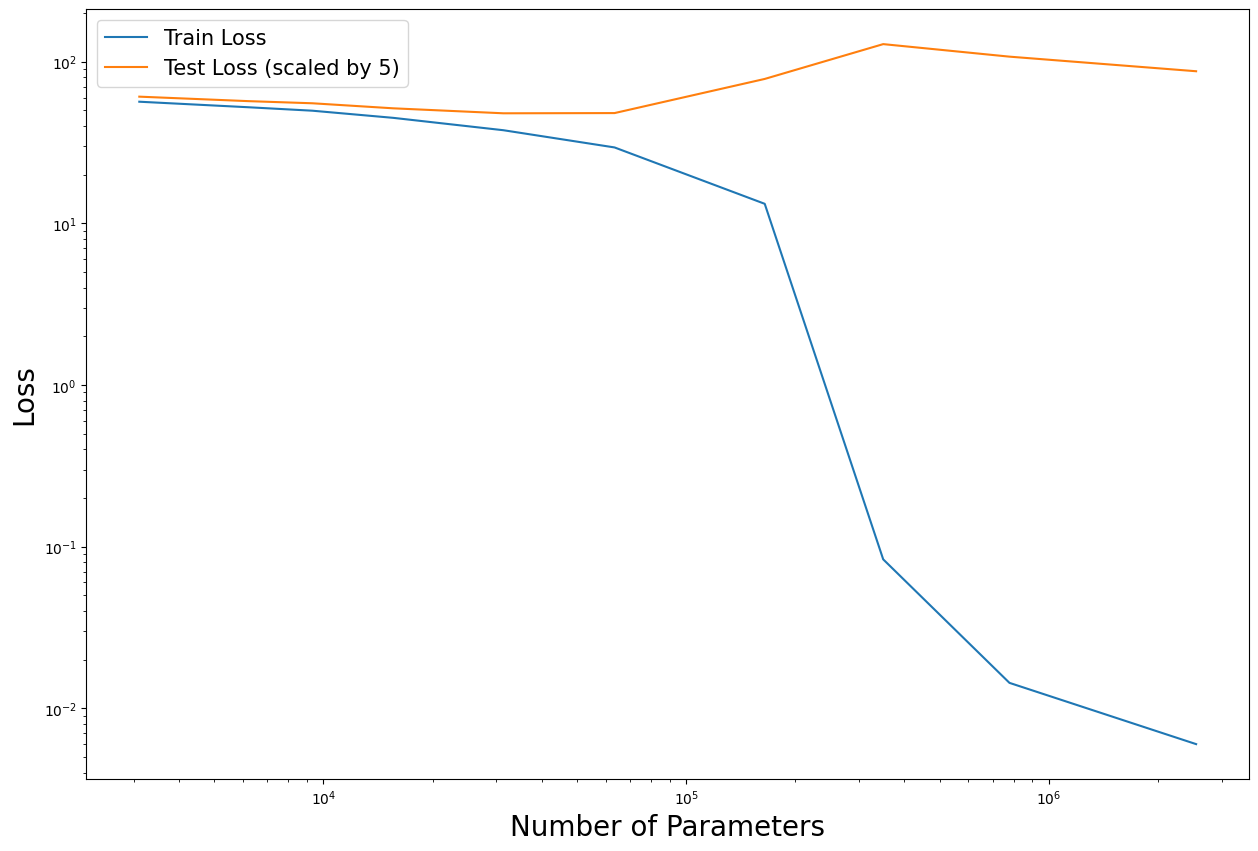

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(num_param_list, train_loss, label='Train Loss')  
plt.plot(num_param_list, [loss * 5 for loss in test_loss], label='Test Loss (scaled by 5)')  
plt.xlabel('Number of Parameters', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xscale('log')  
plt.yscale('log') 
plt.legend(fontsize=15)
plt.show()


In [ ]:
# Flatness v.s. Generalization - part1


In [32]:
def train_model_MNIST(model_class, Epochs=20, Batch=2000, Data_workers=0, LR=0.1):
    # Load datasets
    train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    test_loader = DataLoader(test_dataset, batch_size=Batch, shuffle=False, num_workers=Data_workers)

    # Device configuration
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model_class.to(device)

    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    # Logging metrics
    train_loss_log = []
    test_loss_log = []
    accuracy_log = []
    lr_log = []

    for epoch in range(Epochs):
        model.train()
        total_train_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.view(-1, 28*28).to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Evaluation phase
        model.eval()
        total_test_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.view(-1, 28*28).to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                total_test_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                total_correct += (predictions == targets).sum().item()
                total_samples += targets.size(0)

        accuracy = 100.0 * total_correct / total_samples

        # Log scheduler learning rate
        lr_scheduler.step()
        lr_log.append(optimizer.state_dict()['param_groups'][0]['lr'])
        train_loss_log.append(total_train_loss)
        test_loss_log.append(total_test_loss)
        accuracy_log.append(accuracy)

        # Print epoch results
        print(f'{epoch+1}/{Epochs} Test Set: Avg loss: {total_train_loss:.4f}/{total_test_loss:.4f}, Accuracy: {total_correct}/{total_samples} ({accuracy:.2f}%) lr={lr_log[-1]}')

    return model, train_loss_log, test_loss_log, accuracy_log, lr_log

In [34]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False, num_workers=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10).to(device)
criterion = nn.CrossEntropyLoss()

param_1 = model.state_dict()  # Assuming Model_64 is a typo and meant to be model
param_2 = model.state_dict()  # Assuming Model_2048 is a typo and meant to be model or another model's state_dict

train_loss_log = []
test_loss_log = []
train_accuracy_log = []
test_accuracy_log = []

alpha_list = np.linspace(-2, 2, 50)

for alpha in alpha_list:
    param_new = {key: (1 - alpha) * param_1[key] + alpha * param_2[key] for key in param_1}
    
    model.load_state_dict(param_new)
    model.eval()

    train_loss, correct_train, total_train = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
    total_train = len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_loss_log.append(train_loss / len(train_loader))
    train_accuracy_log.append(train_accuracy)

    test_loss, correct_test, total_test = 0, 0, 0
    for images, labels in test_loader:
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
    total_test = len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    test_loss_log.append(test_loss / len(test_loader))
    test_accuracy_log.append(test_accuracy)

    print(alpha)


-2.0
-1.9183673469387754
-1.836734693877551
-1.7551020408163265
-1.6734693877551021
-1.5918367346938775
-1.510204081632653
-1.4285714285714286
-1.3469387755102042
-1.2653061224489797
-1.183673469387755
-1.1020408163265307
-1.0204081632653061
-0.9387755102040818
-0.8571428571428572
-0.7755102040816328
-0.6938775510204083
-0.6122448979591837
-0.5306122448979593
-0.44897959183673475
-0.3673469387755104
-0.2857142857142858
-0.20408163265306145
-0.12244897959183687
-0.04081632653061229
0.04081632653061229
0.12244897959183643
0.204081632653061
0.2857142857142856
0.36734693877551017
0.4489795918367343
0.5306122448979589
0.6122448979591835
0.693877551020408
0.7755102040816326
0.8571428571428568
0.9387755102040813
1.020408163265306
1.1020408163265305
1.1836734693877546
1.2653061224489792
1.3469387755102038
1.4285714285714284
1.510204081632653
1.591836734693877
1.6734693877551017
1.7551020408163263
1.8367346938775508
1.9183673469387754
2.0


In [35]:
Model_64, train_loss_log_64, test_loss_log_64, accuracy_log_64, lr_log_64 = train_model_MNIST(model_class=CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10), Batch=64)

Model_2048, train_loss_log_2048, test_loss_log_2048, accuracy_log_2048, lr_log_2048 = train_model_MNIST(model_class=CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10), Batch=2048)


1/20 Test Set: Avg loss: 202.7374/15.8729, Accuracy: 9677/10000 (96.77%) lr=0.1
2/20 Test Set: Avg loss: 99.3015/13.6839, Accuracy: 9726/10000 (97.26%) lr=0.1
3/20 Test Set: Avg loss: 73.5472/12.2913, Accuracy: 9743/10000 (97.43%) lr=0.1
4/20 Test Set: Avg loss: 58.2093/11.1003, Accuracy: 9787/10000 (97.87%) lr=0.1
5/20 Test Set: Avg loss: 48.8146/11.4470, Accuracy: 9792/10000 (97.92%) lr=0.08000000000000002
6/20 Test Set: Avg loss: 36.4749/10.3704, Accuracy: 9809/10000 (98.09%) lr=0.08000000000000002
7/20 Test Set: Avg loss: 29.9690/9.5680, Accuracy: 9831/10000 (98.31%) lr=0.08000000000000002
8/20 Test Set: Avg loss: 27.1217/10.6933, Accuracy: 9799/10000 (97.99%) lr=0.08000000000000002
9/20 Test Set: Avg loss: 25.8693/10.1549, Accuracy: 9839/10000 (98.39%) lr=0.08000000000000002
10/20 Test Set: Avg loss: 20.6354/11.7403, Accuracy: 9808/10000 (98.08%) lr=0.06400000000000002
11/20 Test Set: Avg loss: 16.4055/11.2447, Accuracy: 9792/10000 (97.92%) lr=0.06400000000000002
12/20 Test Set: A

In [36]:
Model_1e3, train_loss_log_1e3, test_loss_log_1e3, accuracy_log_1e3, lr_log_1e3 = train_model_MNIST(model_class=CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10), LR=0.001)

Model_1e2, train_loss_log_1e2, test_loss_log_1e2, accuracy_log_1e2, lr_log_1e2 = train_model_MNIST(model_class=CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10), LR=0.01)


1/20 Test Set: Avg loss: 62.0154/9.8448, Accuracy: 5891/10000 (58.91%) lr=0.001
2/20 Test Set: Avg loss: 43.1336/6.1146, Accuracy: 7724/10000 (77.24%) lr=0.001
3/20 Test Set: Avg loss: 32.8233/4.7611, Accuracy: 8181/10000 (81.81%) lr=0.001
4/20 Test Set: Avg loss: 26.7478/3.9659, Accuracy: 8511/10000 (85.11%) lr=0.001
5/20 Test Set: Avg loss: 22.6295/3.3933, Accuracy: 8743/10000 (87.43%) lr=0.0008
6/20 Test Set: Avg loss: 19.8571/3.0421, Accuracy: 8870/10000 (88.70%) lr=0.0008
7/20 Test Set: Avg loss: 17.9147/2.7556, Accuracy: 8955/10000 (89.55%) lr=0.0008
8/20 Test Set: Avg loss: 16.3386/2.5182, Accuracy: 9024/10000 (90.24%) lr=0.0008
9/20 Test Set: Avg loss: 15.0315/2.3269, Accuracy: 9086/10000 (90.86%) lr=0.0008
10/20 Test Set: Avg loss: 13.9504/2.1663, Accuracy: 9124/10000 (91.24%) lr=0.00064
11/20 Test Set: Avg loss: 13.1006/2.0500, Accuracy: 9139/10000 (91.39%) lr=0.00064
12/20 Test Set: Avg loss: 12.4621/1.9548, Accuracy: 9164/10000 (91.64%) lr=0.00064
13/20 Test Set: Avg loss: 

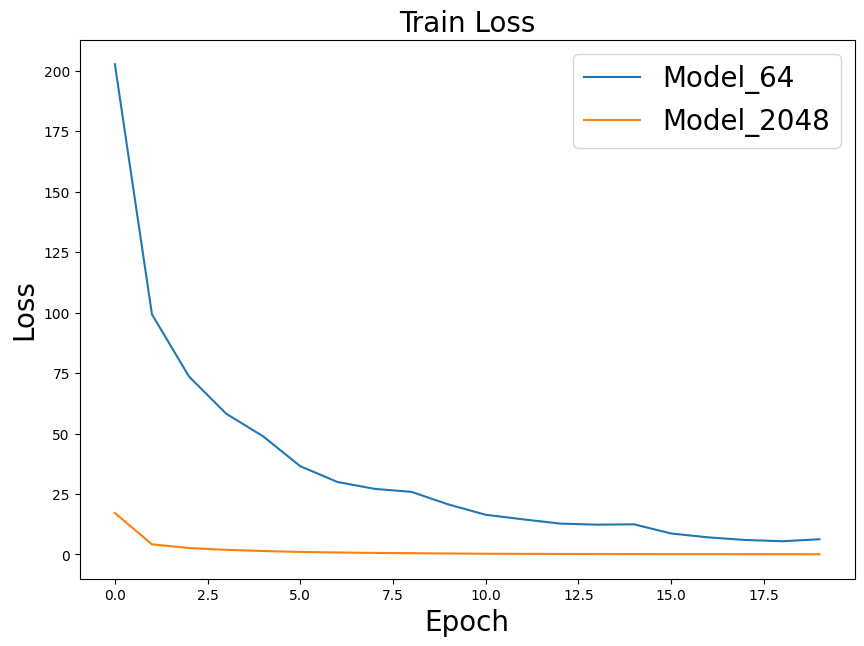

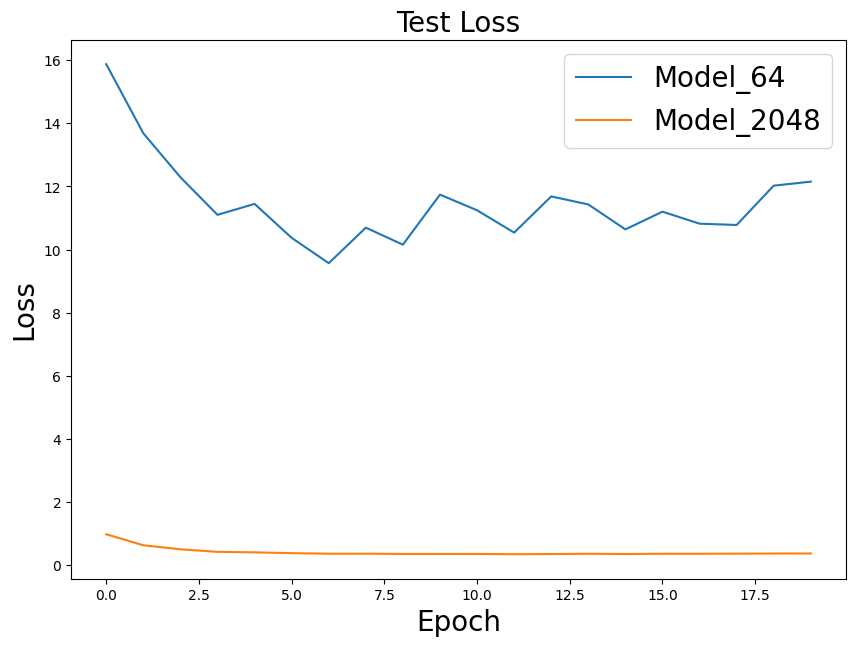

In [37]:

plt.figure(figsize=(10, 7))
plt.plot(train_loss_log_64, label='Model_64')
plt.plot(train_loss_log_2048, label='Model_2048')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Train Loss', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('train_loss_comparison.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(test_loss_log_64, label='Model_64')
plt.plot(test_loss_log_2048, label='Model_2048')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Test Loss', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('test_loss_comparison.png')
plt.show()


In [38]:
train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False, num_workers=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CustomDNN_MNIST_4Layers(28*28, 100, 200, 100, 10).to(device)
criterion = nn.CrossEntropyLoss()

param_1 = Model_1e3.state_dict()
param_2 = Model_1e2.state_dict()

linear_combination_train_loss = []
linear_combination_train_accuracy = []
linear_combination_test_loss = []
linear_combination_test_accuracy = []

alpha_list = np.linspace(0, 1, 50)

for alpha in alpha_list:
    param_new = {key: (1 - alpha) * param_1[key] + alpha * param_2[key] for key in param_1}

    model.load_state_dict(param_new)
    model.eval()

    train_loss, correct_train, total_train = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
    total_train = len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    linear_combination_train_loss.append(train_loss / len(train_loader))
    linear_combination_train_accuracy.append(train_accuracy)

    test_loss, correct_test, total_test = 0, 0, 0
    for images, labels in test_loader:
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
    total_test = len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    linear_combination_test_loss.append(test_loss / len(test_loader))
    linear_combination_test_accuracy.append(test_accuracy)

    print('alpha:', alpha)

alpha: 0.0
alpha: 0.02040816326530612
alpha: 0.04081632653061224
alpha: 0.061224489795918366
alpha: 0.08163265306122448
alpha: 0.1020408163265306
alpha: 0.12244897959183673
alpha: 0.14285714285714285
alpha: 0.16326530612244897
alpha: 0.18367346938775508
alpha: 0.2040816326530612
alpha: 0.22448979591836732
alpha: 0.24489795918367346
alpha: 0.26530612244897955
alpha: 0.2857142857142857
alpha: 0.3061224489795918
alpha: 0.32653061224489793
alpha: 0.3469387755102041
alpha: 0.36734693877551017
alpha: 0.3877551020408163
alpha: 0.4081632653061224
alpha: 0.42857142857142855
alpha: 0.44897959183673464
alpha: 0.4693877551020408
alpha: 0.4897959183673469
alpha: 0.5102040816326531
alpha: 0.5306122448979591
alpha: 0.5510204081632653
alpha: 0.5714285714285714
alpha: 0.5918367346938775
alpha: 0.6122448979591836
alpha: 0.6326530612244897
alpha: 0.6530612244897959
alpha: 0.673469387755102
alpha: 0.6938775510204082
alpha: 0.7142857142857142
alpha: 0.7346938775510203
alpha: 0.7551020408163265
alpha: 0.775

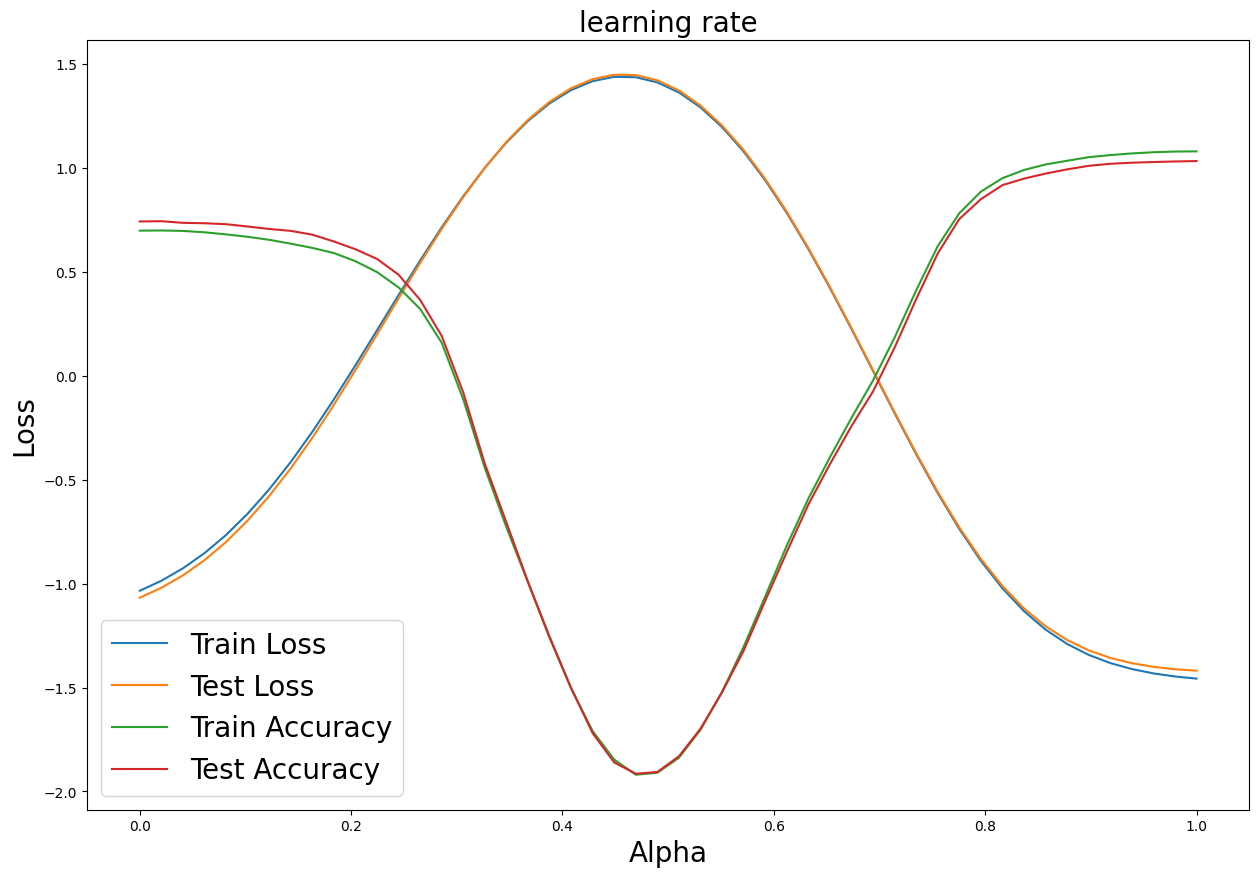

/tmp/ipykernel_760/1075999994.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)


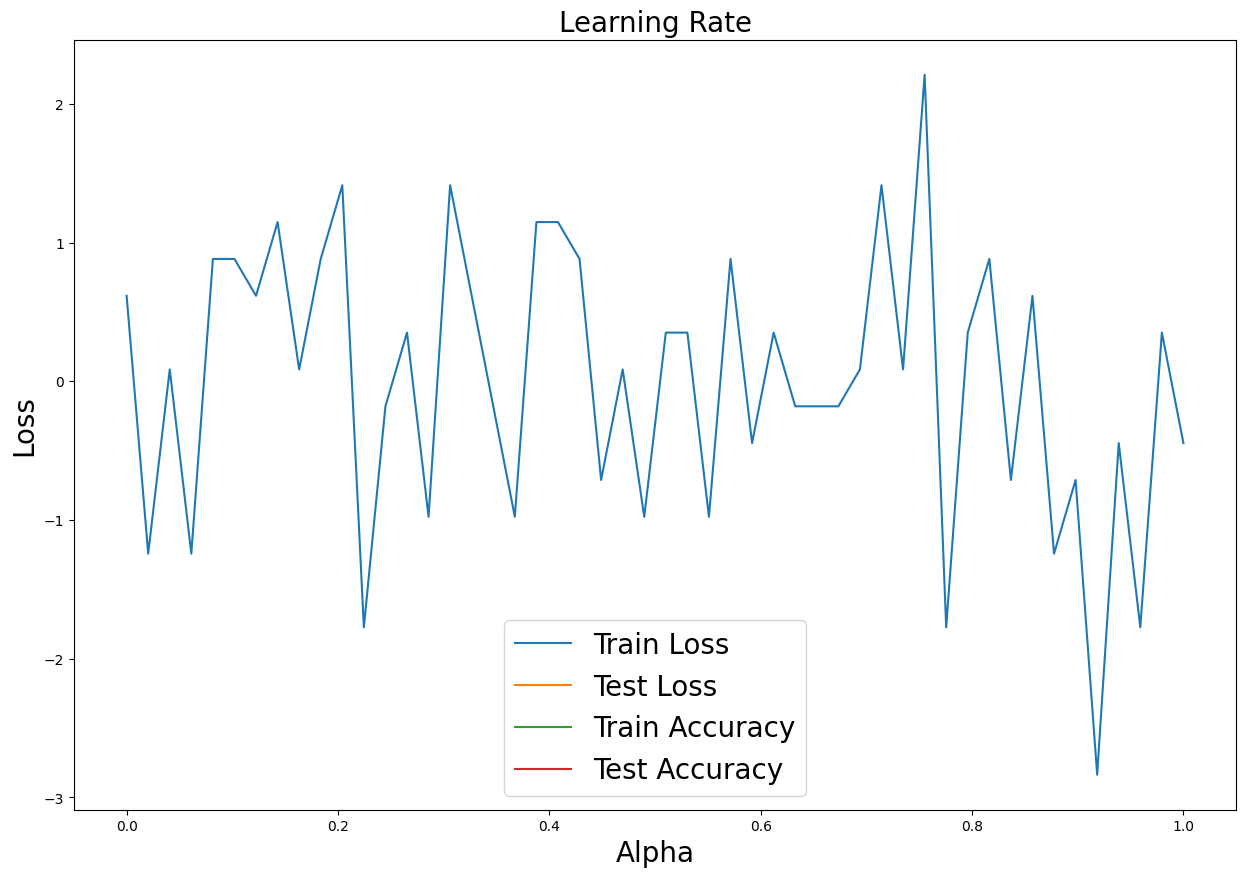

In [45]:
plt.figure(figsize=(15,10))
plt.plot(alpha_list,standardization(linear_combination_train_loss), label='Train Loss')
plt.plot(alpha_list,standardization(linear_combination_test_loss),label='Test Loss')
plt.plot(alpha_list,standardization(linear_combination_train_accuracy),label='Train Accuracy')
plt.plot(alpha_list,standardization(linear_combination_test_accuracy),label='Test Accuracy')
plt.xlabel('Alpha',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('learning rate',fontsize=20)
plt.legend(fontsize=20)
plt.show()




plt.figure(figsize=(15,10))
plt.plot(alpha_list,standardization(train_loss_log), label='Train Loss')
plt.plot(alpha_list,standardization(test_loss_log), label='Test Loss')
plt.plot(alpha_list,standardization(train_accuracy_log), label='Train Accuracy')
plt.plot(alpha_list,standardization(test_accuracy_log), label='Test Accuracy')
plt.xlabel('Alpha',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('batch size',fontsize=20)
plt.legend(fontsize=20)
plt.show()